In [1]:
import pandas as pd 
import numpy as np
import os
import json
import geopandas as gpd
from shapely.geometry import Point
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
warnings.filterwarnings("ignore")

In [2]:
def outlier_filtering(df, column, quantile=0.95):
    quantile_value = df[column].quantile(quantile)
    df = df[df[column] < quantile_value]
    return df, quantile_value

In [26]:
def filter_visualization(column1, column2, quantile_value):
    # font style: times new roman
    plt.rcParams['font.family'] = 'Times New Roman'
    colors = sns.color_palette('husl', 10)
    plt.figure(figsize=(6, 5))

    # Plot 1: Histogram of original data
    plt.subplot(2, 1, 1)
    sns.histplot(column1, bins=100, kde=False, color=colors[6], edgecolor='black')
    plt.axvline(quantile_value, color=colors[0], linestyle='--', label=f'Threshold: {quantile_value / 1000:.2f} MWh/a')
    plt.text(quantile_value*2.5, plt.gca().get_ylim()[1] * 0.9, 
            f"Threshold: {quantile_value / 1000:.2f} MWh/a", 
            color='black', ha='left', fontsize=10)
    plt.xlabel('Generation (kWh/a)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Original Data', fontsize=12)
    plt.legend()

    # Plot 2: Histogram of filtered data
    plt.subplot(2, 1, 2)
    sns.histplot(column2, bins=100, kde=False, color=colors[6], edgecolor='black')
    plt.xlabel('Generation (kWh/a)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Filtered Data by 95th Percentile', fontsize=12)

    # Adjust layout for better visualization
    plt.tight_layout()
    plt.savefig('PV_output/picture/filter_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

In [27]:
# Load PV data
script_path = os.getcwd()
mother_path = os.path.dirname(script_path)
PV_data = pd.read_csv(os.path.join(script_path, 'PV_data', 'rooftop_PV_CH_annual_by_building.csv'))

Step 0: filterout PV generation data, according to 95% quantile

In [7]:
filtered_PV_data, quantile_value = outlier_filtering(PV_data, 'EPV_kWh_a', 0.95)
filtered_PV_data.to_csv(os.path.join(script_path, 'PV_data', 'rooftop_PV_CH_annual_by_building_filtered.csv'), index=False)

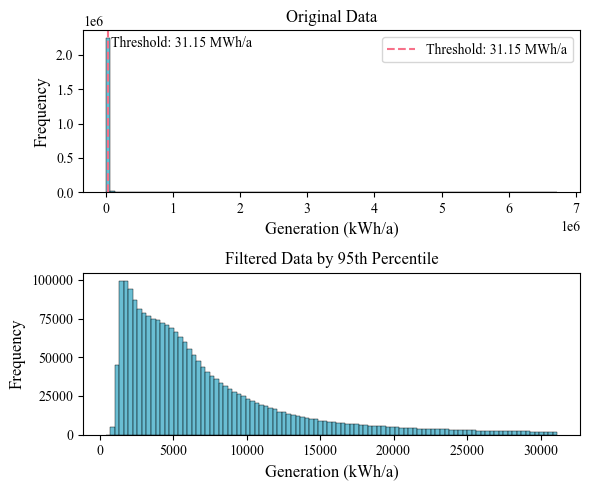

In [28]:
filter_visualization(PV_data['EPV_kWh_a'], filtered_PV_data['EPV_kWh_a'], quantile_value)

Step 1: split the PV data according to the geometry of 2151 municipality, preparing for the mpi calculation. \
Script: PV_split.py \
Return: PV_split folder



Step 2: allocation PV data to LV node\
script: PV_allocation_parellel.py\
input: PV_split folder\
output: PV_allocation_LV.csv

Step 3: load the LV allocation data and filter out the outliers

In [9]:
LV_allocation = pd.read_csv(os.path.join(script_path, 'PV_data', 'PV_allocation_LV.csv'))

In [10]:
LV_allocation = LV_allocation[LV_allocation['LV_grid']!='-1']

In [11]:
def data_aggregate(building_data_part):
    building_copy = building_data_part.copy()
    building_copy = building_copy.drop(columns=['geometry', 'SB_UUID'])
   
    # Aggregate other building data by summing numerical columns
    building_data_0 = (
        building_copy.groupby(['LV_grid', 'LV_osmid'], as_index=False).sum())
    # Map the most frequent T_PROFILE back to the grouped data
    building_data_0 = building_data_0.set_index(['LV_grid', 'LV_osmid'])
    building_data_0 = building_data_0.reset_index()
    return building_data_0

In [12]:
LV_allocation_by_grid = data_aggregate(LV_allocation)

In [13]:
LV_allocation_filtered, quantile_value = outlier_filtering(LV_allocation_by_grid, 'EPV_kWh_a', 0.95)

In [14]:
filtered_pair = LV_allocation_by_grid[~LV_allocation_by_grid.index.isin(LV_allocation_filtered.index)][['LV_grid', 'LV_osmid']]
filtered_pair = filtered_pair.drop_duplicates()
pairs = [tuple(row) for row in filtered_pair[['LV_grid', 'LV_osmid']].values]
LV_processed = LV_allocation[
    ~LV_allocation[['LV_grid', 'LV_osmid']].apply(tuple, axis=1).isin(pairs)]

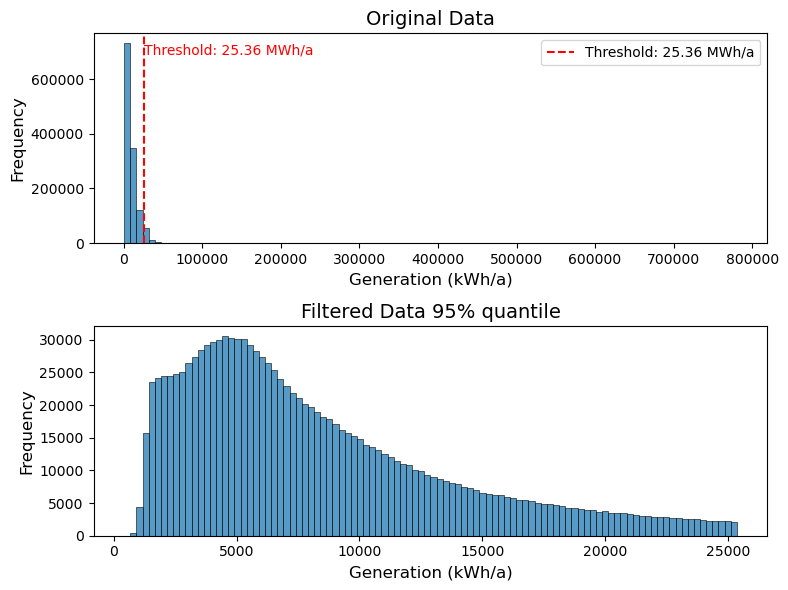

In [15]:
#plot the filtered data
filter_visualization(LV_allocation_by_grid['EPV_kWh_a'], LV_allocation_filtered['EPV_kWh_a'], quantile_value)

Step 4: allocation PVs that are not allocated to MV node

In [15]:
PV_data_origin = PV_data

In [16]:
# Extract matched rows
matched_rows_df = PV_data_origin[
    PV_data_origin['SB_UUID'].isin(LV_processed[LV_processed['LV_grid'] != '-1']['SB_UUID'])
]
# Extract unmatched rows
unmatched_rows_df = PV_data_origin[
    ~PV_data_origin['SB_UUID'].isin(LV_processed[LV_processed['LV_grid'] != '-1']['SB_UUID'])
]
a=len(matched_rows_df)/len(PV_data_origin)
b=len(unmatched_rows_df)/len(PV_data_origin)
c=a+b
# Verify counts
print(f"Matched rows: {a}")
print(f"Unmatched rows: {b}")
print(f"Total: {c}")

Matched rows: 0.690480939478279
Unmatched rows: 0.309519060521721
Total: 1.0


In [17]:
MV_filtered, outlier_threshold = outlier_filtering(unmatched_rows_df, 'EPV_kWh_a', quantile=0.95)
MV_filtered.to_csv(os.path.join(script_path, 'PV_data', 'rooftop_PV_CH_annual_by_building_MV.csv'), index=False)

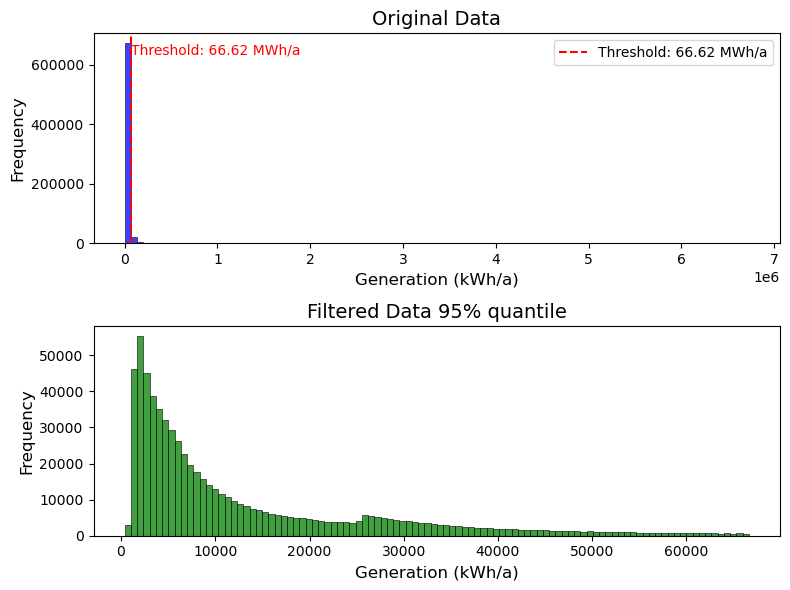

In [18]:
# visualize the filtered data
filter_visualization(unmatched_rows_df['EPV_kWh_a'], MV_filtered['EPV_kWh_a'], outlier_threshold)

Step 5: allocation PVs to MV nodes\
Load the processed PV data\
Filter out outliers by generation feed in per node\
Input: rooftop_PV_CH_annual_by_building_MV_processed.csv

In [19]:
MV_processed = pd.read_csv(os.path.join(script_path, 'PV_data', 'rooftop_PV_CH_annual_by_building_MV_processed.csv'))

In [20]:
len(MV_processed[MV_processed['MV_grid']!='-1'])/len(MV_filtered)

0.9377949058164932

In [21]:
def data_aggregate_MV(building_data_part):
    building_copy = building_data_part.copy()
    building_copy = building_copy.drop(columns=['geometry', 'SB_UUID'])
   
    # Aggregate other building data by summing numerical columns
    building_data_0 = (
        building_copy.groupby(['MV_grid', 'MV_osmid'], as_index=False).sum())
    # Map the most frequent T_PROFILE back to the grouped data
    building_data_0 = building_data_0.set_index(['MV_grid', 'MV_osmid'])
    building_data_0 = building_data_0.reset_index()
    return building_data_0

In [22]:
MV_by_grid = data_aggregate_MV(MV_processed)
MV_by_grid_filtered, quantile_value = outlier_filtering(MV_by_grid, 'EPV_kWh_a', 0.95)

In [23]:
filtered_pair_MV = MV_by_grid[~MV_by_grid.index.isin(MV_by_grid_filtered.index)][['MV_grid', 'MV_osmid']]
filtered_pair_MV = filtered_pair_MV.drop_duplicates()
pairs_MV = [tuple(row) for row in filtered_pair_MV[['MV_grid', 'MV_osmid']].values]
MV_processed = MV_processed[
    ~MV_processed[['MV_grid', 'MV_osmid']].apply(tuple, axis=1).isin(pairs_MV)]

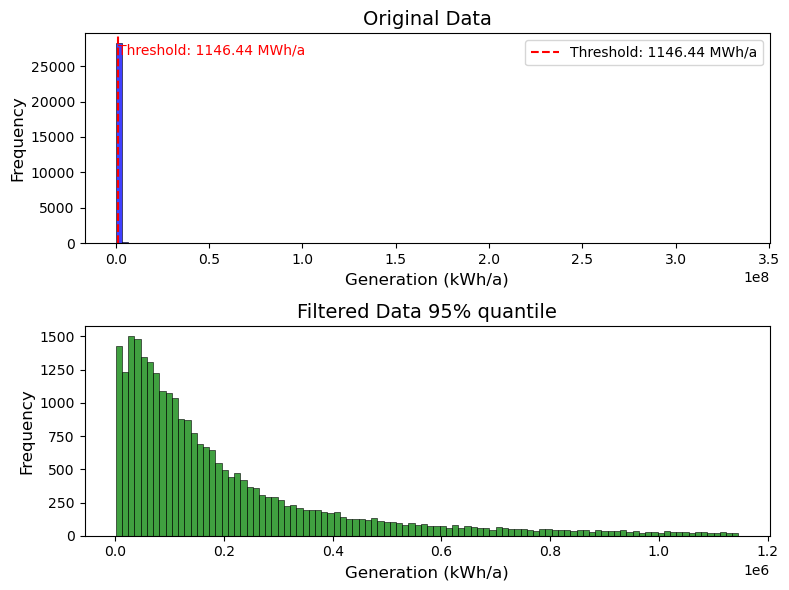

In [24]:
# visualize the filtered data
filter_visualization(MV_by_grid['EPV_kWh_a'], MV_by_grid_filtered['EPV_kWh_a'], quantile_value)

Step 6: Save the LV and MV result to separate csv file\


In [12]:
# load time series data
generation_ts = pd.read_csv(os.path.join(script_path, 'PV_data', 'rooftop_PV_CH_EPV_W_by_building.csv'),low_memory=False)
deviation_ts = pd.read_csv(os.path.join(script_path, 'PV_data', 'rooftop_PV_CH_EPV_W_std_by_building.csv'),low_memory=False)
irradiance_ts = pd.read_csv(os.path.join(script_path, 'PV_data', 'rooftop_PV_CH_Gt_W_m2_by_building.csv'),low_memory=False)

In [14]:
with open(os.path.join(mother_path, 'data_processing', 'file_folder_lv.json')) as f:
    file_folder_lv = json.load(f)

In [15]:
def fill_missing_hour(data):
    df = data.copy()
    df.set_index('SB_UUID', inplace=True)
    df.columns = pd.to_datetime(df.columns)
    unique_days = df.columns.normalize().unique()
    full_columns = pd.DatetimeIndex([]) 
    for day in unique_days:
        full_columns = full_columns.append(pd.date_range(day, periods=24, freq='H'))
    df_full = df.reindex(columns=full_columns, fill_value=0)
    df_full.reset_index(inplace=True)
    return df_full

def mapping(PV_building, df, type):
    grid_dict = dict(zip(PV_building['SB_UUID'], PV_building[f'{type}_grid']))
    osmid_dict = dict(zip(PV_building['SB_UUID'], PV_building[f'{type}_osmid']))
    df[f'{type}_grid'] = df['SB_UUID'].map(grid_dict)
    df[f'{type}_osmid'] = df['SB_UUID'].map(osmid_dict)
    df = df[df[f'{type}_grid'].notna()]
    return df

def area_calculation(id, PV_generation_data, irradiance_data, type):
    osmid = PV_generation_data[f'{type}_osmid']
    P_data =pd.DataFrame(columns=[f'{type}_grid',f'{type}_osmid', 'P_installed (kWp)'])
    PV_generation_data = PV_generation_data.loc[:, (PV_generation_data != 0).any(axis=0)]
    irradiance_data = irradiance_data.loc[:, (irradiance_data != 0).any(axis=0)]
    area = PV_generation_data.iloc[:,1:]/(irradiance_data.iloc[:,1:]*0.138)
    area = area.replace(0, np.nan)
    area = area.fillna(area.mean(axis=1))
    area['mean'] = area.mean(axis=1)
    P_installed = 285*area['mean']/(1.6*10**3) #kWp
    P_data[f'{type}_grid'] = [id]*len(P_installed)
    try:
        P_data[f'{type}_osmid'] = PV_generation_data[f'{type}_osmid']
    except:
        P_data[f'{type}_osmid'] = osmid
    P_data['P_installed (kWp)'] = P_installed
    return P_data

def allocation(PV_building, df_time_series_avg, df_std_avg,df_ir,id, type):
    pv_time_series_part = df_time_series_avg[df_time_series_avg[f'{type}_grid'] == id]
    pv_std_part = df_std_avg[df_std_avg[f'{type}_grid'] == id]
    pv_ir_part = df_ir[df_ir[f'{type}_grid'] == id]
        
    pv_time_series_part = pv_time_series_part.reset_index(drop=True)
    pv_time_series_part = pv_time_series_part.drop(f'{type}_grid', axis=1)
    data2 = pv_time_series_part.drop('SB_UUID', axis=1).groupby(f'{type}_osmid', dropna=False).sum()
    data2 = data2.reset_index(inplace=False)
    
    pv_std_part = pv_std_part.reset_index(drop=True)
    pv_std_part = pv_std_part.drop(f'{type}_grid', axis=1)
    data3 = pv_std_part.drop('SB_UUID', axis=1).groupby(f'{type}_osmid', dropna=False).sum()
    data3 = data3.reset_index(inplace=False)
    
    pv_ir_part = pv_ir_part.reset_index(drop=True)
    pv_ir_part = pv_ir_part.drop(f'{type}_grid', axis=1)
    data4 = pv_ir_part.drop('SB_UUID', axis=1).groupby(f'{type}_osmid', dropna=False).sum()
    data4 = data4.reset_index(inplace=False)
    
    # if f['{type}_osmid'] not in the first column of data2, data4, put them in the first column
    if data2.columns[0] != f'{type}_osmid':
        data2 = data2[[f'{type}_osmid']+list(data2.columns)[:-1]]
        data3 = data3[[f'{type}_osmid']+list(data3.columns)[:-1]]
        data4 = data4[[f'{type}_osmid']+list(data4.columns)[:-1]]
    P_data = data4.copy()
  
    P_data = area_calculation(id, data2, data4, type)
    if type == 'MV':
        save_path = script_path+f'/PV_output/PV_allocation_{type}'
    else:
        save_path = script_path+f'/PV_output/PV_allocation_{type}/'+file_folder_lv[str(id)]
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    # create folder for each MV grid
    if not os.path.exists(save_path+'/'+ str(id)):
        os.makedirs(save_path+'/' + str(id))
    # save data2 and data3 as csv files, named by MV grid id+demand or std
    data2.to_csv(save_path+'/'+ str(id) + '/' + str(id) + '_generation.csv')
    data3.to_pickle(save_path+'/'+ str(id) + '/' + str(id) + '_std.csv')
    P_data.to_csv(save_path+'/'+ str(id) + '/' + str(id) + '_P_installed.csv', index=False)
    return data2, data3, P_data

In [13]:
PV_time_series = fill_missing_hour(generation_ts.copy())
PV_std = fill_missing_hour(deviation_ts.copy())
PV_time_series_area = fill_missing_hour(irradiance_ts.copy())

df_time_series = mapping(MV_processed, PV_time_series, 'MV')
df_std = mapping(MV_processed, PV_std, 'MV')
df_time_series_area = mapping(MV_processed, PV_time_series_area, 'MV')

NameError: name 'fill_missing_hour' is not defined

In [65]:
MV_grids_ids = MV_processed['MV_grid'].unique()
# rearrange the order of MV grid ids to start with the smallest id
MV_grids_ids = np.sort(MV_grids_ids)
for grid_id in tqdm.tqdm(MV_grids_ids):
    data2, data3,  P_data =allocation(MV_processed, df_time_series, df_std, df_time_series_area,grid_id, 'MV')

100%|██████████| 749/749 [03:14<00:00,  3.85it/s]


In [16]:
PV_time_series = fill_missing_hour(generation_ts.copy())
PV_std = fill_missing_hour(deviation_ts.copy())
PV_time_series_area = fill_missing_hour(irradiance_ts.copy())

df_time_series = mapping(LV_processed, PV_time_series, 'LV')
df_std = mapping(LV_processed, PV_std, 'LV')
df_time_series_area = mapping(LV_processed, PV_time_series_area, 'LV')

In [17]:
# allocation of LV grid
LV_grids_ids = LV_processed['LV_grid'].unique()
# rearrange the order of LV grid ids to start with the smallest id
LV_grids_ids = np.sort(LV_grids_ids)
for grid_id in tqdm.tqdm(LV_grids_ids[20100:]):
    data2,data3,P_data =allocation(LV_processed, df_time_series, df_std, df_time_series_area,grid_id, 'LV')

100%|██████████| 13812/13812 [2:47:10<00:00,  1.38it/s]  
